In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import RNN, Dense, Layer, Input
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow import float32, concat, convert_to_tensor, linalg

In [44]:
class EulerMaruyamaIntegratorCell(Layer):
    def __init__(self, W, L, r_m, k, k_plus, k_e, dt, initial_state, epsilon, **kwargs):
        super(EulerMaruyamaIntegratorCell, self).__init__(**kwargs)
        self.W = tf.convert_to_tensor(W, dtype=tf.float32)
        self.L = tf.convert_to_tensor(L, dtype=tf.float32)
        self.r_m = r_m
        self.k = k
        self.k_plus = k_plus
        self.k_e = k_e
        self.initial_state = initial_state
        self.state_size = len(initial_state)
        self.dt = dt
        self.epsilon = epsilon

    def build(self, input_shape, **kwargs):
        self.built = True

    def call(self, inputs, states):
        y = states[0]
        s = y[:, :4]
        ydot = self._fun(y)
        
        noise_forcing = tf.sqrt(self.dt) * (2 * tf.sqrt(tf.cast(2, dtype=tf.float32)) / self.k_e) * tf.random.normal(shape=(), mean=0, stddev=1, dtype=tf.float32)
        noise_forcing_vector = tf.stack([noise_forcing, 0, 0, 0], axis=-1)
        
        s_next = s + ydot[:, :4] * self.dt + tf.sqrt(tf.cast(self.epsilon, dtype=tf.float32)) * noise_forcing_vector 
        U = y[:, 4]
        U_next = U + self.dt * ((0.25 * self.k * (self.k_plus**2 - self.k_e**2) * s[:, 0] * s[:, 2]) - (self.r_m * U))
        y_next = tf.concat([s_next, tf.expand_dims(U_next, axis=-1)], axis=-1)
        return y_next, [y_next]

    def _fun(self, y):
        U = y[:, 4]
        s = y[:, :4]
        ydot = tf.matmul(s, self.W) + U[..., None] * tf.matmul(s, self.L)
        ydot = tf.concat([ydot[:, :4], tf.expand_dims((0.25 * self.k * (self.k_plus**2 - self.k_e**2) * y[:, 0] * y[:, 2]) - (self.r_m * U), axis=-1)], axis=-1)
        return ydot

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.initial_state

In [45]:
def create_model(W, L, r_m, k, k_plus, k_e, dt, initial_state, epsilon, batch_input_shape, return_sequences=True, unroll=False):
    emCell = EulerMaruyamaIntegratorCell(W, L, r_m, k, k_plus, k_e, dt, initial_state, epsilon)
    PINN = RNN(cell=emCell, batch_input_shape=batch_input_shape, return_sequences=return_sequences, return_state=False, unroll=unroll)
    model = Sequential()
    model.add(PINN)
    model.compile(loss='mse', optimizer=RMSprop(1e-4), metrics=['mae'])
    return model

In [46]:
# Parameters
k = tf.constant(12 * np.pi, dtype=tf.float32)
m = tf.constant(6 * np.pi, dtype=tf.float32)
m_U = tf.constant(14 * np.pi, dtype=tf.float32)

# Other parameters
r_m = tf.constant(0.1, dtype=tf.float32)
N0_squared = tf.constant(100, dtype=tf.float32)

k_e = tf.sqrt(k**2 + m**2)
k_plus = tf.sqrt(k**2 + (m + m_U)**2)


W_e = np.array([[-1, k / (k_e**2)],[-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],[k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],[np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],[0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],[0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],[L_plus, np.zeros((2, 2))]])

dt = tf.constant(0.001, dtype=tf.float32)
initial_state = tf.constant([[0, 0, 0, 0, 0.001]], dtype=tf.float32)
epsilon = tf.constant(0.01, dtype=tf.float32)

# Data
# Load the training data
train_df = pd.read_csv('./data/train_data.csv')
t_train = train_df[['t']].values
y_train_input = train_df[['t', 'psi_e', 'b_e', 'psi_plus', 'b_plus']].values
y_train_output = train_df[['U']].values

# Reshape the data for the neural network
y_train_input = y_train_input[np.newaxis, :, :]
y_train_output = y_train_output[np.newaxis, :, :]

# Reshape the data for the neural network
#ytrain = utrain.reshape(1, -1, 1)

# Fitting physics-informed neural network
model = create_model(W, L, r_m, k, k_plus, k_e, dt, initial_state=initial_state, epsilon=epsilon, batch_input_shape=y_train_input.shape)
yPred_before = model.predict_on_batch(y_train_input)[0, :, :]
model.fit(y_train_input, y_train_output, epochs=150, steps_per_epoch=1, verbose=1)
yPred = model.predict_on_batch(y_train_input)[0, :, :]

2023-05-31 22:54:38.084713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,200001,5]
	 [[{{node Placeholder/_0}}]]


Epoch 1/150
1/1 [==============================] - 17s 17s/step - loss: 0.0140 - mae: 0.1035
Epoch 2/150
1/1 [==============================] - 16s 16s/step - loss: 0.0140 - mae: 0.1035
Epoch 3/150
1/1 [==============================] - 16s 16s/step - loss: 0.0140 - mae: 0.1035
Epoch 4/150
1/1 [==============================] - 16s 16s/step - loss: 0.0140 - mae: 0.1035
Epoch 5/150
1/1 [==============================] - 16s 16s/step - loss: 0.0140 - mae: 0.1035
Epoch 6/150
1/1 [==============================] - 16s 16s/step - loss: 0.0140 - mae: 0.1035
Epoch 7/150
1/1 [==============================] - 16s 16s/step - loss: 0.0140 - mae: 0.1035
Epoch 8/150
1/1 [==============================] - 16s 16s/step - loss: 0.0140 - mae: 0.1035
Epoch 9/150
1/1 [==============================] - 16s 16s/step - loss: 0.0140 - mae: 0.1035
Epoch 10/150
1/1 [==============================] - 16s 16s/step - loss: 0.0140 - mae: 0.1035
Epoch 11/150
1/1 [==============================] - 16s 16s/step - lo

2023-05-31 23:34:51.854154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,200001,5]
	 [[{{node Placeholder/_0}}]]


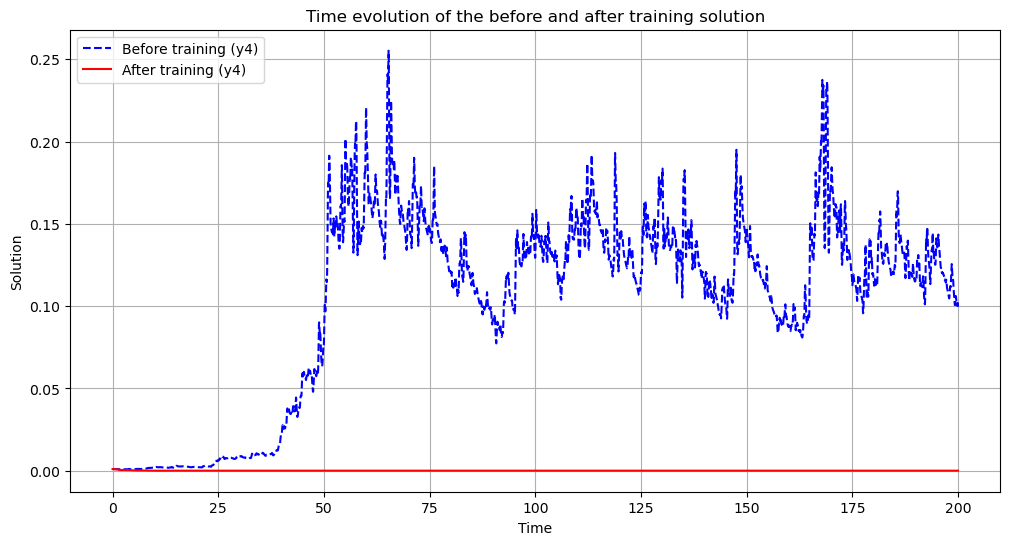

In [76]:
# plotting prediction results

plt.figure(figsize=(12, 6))
plt.plot(t_train, y_train_output[0,:, 0], 'b--', label='Before training (y4)')

plt.plot(t_train, yPred[:, 4], 'r-', label='After training (y4)')

plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Time evolution of the before and after training solution')
#plt.xlim(0,10)
plt.legend()
plt.grid(True)
plt.show()

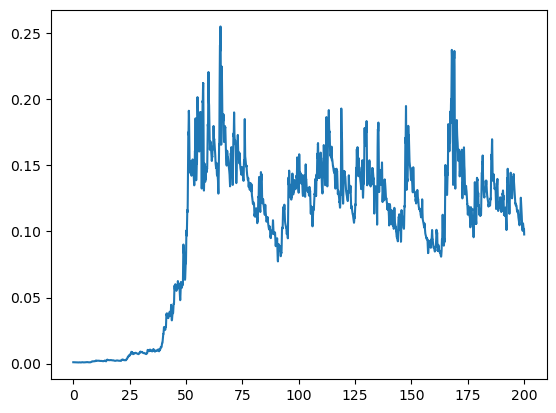

In [72]:
plt.plot(t_train, np.squeeze(y_train_output))

In [52]:
train_df = pd.read_csv('./data/train_data.csv')
t_train = train_df[['t']].values
y_train_input = train_df[['t', 'psi_e', 'b_e', 'psi_plus', 'b_plus']].values
y_train_output = train_df[['U']].values

# Reshape the data for the neural network
y_train_input = y_train_input[np.newaxis, :, :]
y_train_output = y_train_output[np.newaxis, :, :]

print("y_train_input shape:", y_train_input.shape)
print("y_train_input dtype:", y_train_input.dtype)

y_train_input shape: (1, 200001, 5)
y_train_input dtype: float64


In [78]:
# Parameters
k = tf.constant(12 * np.pi, dtype=tf.float32)
m = tf.constant(6 * np.pi, dtype=tf.float32)
m_U = tf.constant(14 * np.pi, dtype=tf.float32)

# Other parameters
r_m = tf.constant(0.1, dtype=tf.float32)
N0_squared = tf.constant(100, dtype=tf.float32)

k_e = tf.sqrt(k**2 + m**2)
k_plus = tf.sqrt(k**2 + (m + m_U)**2)


W_e = np.array([[-1, k / (k_e**2)],[-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],[k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],[np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],[0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],[0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],[L_plus, np.zeros((2, 2))]])

dt = tf.constant(0.001, dtype=tf.float32)
initial_state = tf.constant([[0, 0, 0, 0, 0.001]], dtype=tf.float32)
epsilon = tf.constant(0.01, dtype=tf.float32)

# Data
# Load the training data
train_df = pd.read_csv('./data/train_data.csv')
t_train = train_df[['t']].values
y_train = train_df[['t', 'psi_e', 'b_e', 'psi_plus', 'b_plus', 'U']].values

# Reshape the data for the neural network
y_train = y_train[np.newaxis, :, :]

# Reshape the data for the neural network
y_train = y_train.reshape(1, -1, 1)

# Fitting physics-informed neural network
model = create_model(W, L, r_m, k, k_plus, k_e, dt, initial_state=initial_state, epsilon=epsilon, batch_input_shape=y_train.shape)
yPred_before = model.predict_on_batch(y_train)[0, :, :]
model.fit(y_train, y_train, epochs=3, steps_per_epoch=1, verbose=1)
yPred = model.predict_on_batch(y_train)[0, :, :]

2023-06-01 14:31:18.436693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,800004,1]
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

In [80]:
train_df = pd.read_csv('./data/train_data.csv')
t_train = train_df[['t']].values
y_train = train_df[['t', 'psi_e', 'b_e', 'psi_plus', 'b_plus', 'U']].values

# Reshape the data for the neural network
y_train = y_train[np.newaxis, :, :]

# Reshape the data for the neural network
y_train = y_train.reshape(1, -1, 1)

In [81]:
y_train.shape

(1, 1200006, 1)

In [82]:
print(y_train)

[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.00077535]
  [ 0.29673943]
  [ 0.09772548]]]
